
## Sourabh Ghosh - CIS 731 - HW2


### Timeseries Forecasting & Model Performance Comparison for US Liquor Sales (1980-2007)

### Comparing change across (FNN,BPTT,LSTM,GRU)

#### Dataset : Monthly U.S. Liquor Sales (1980-2007) - csv file (http://course1.winona.edu/bdeppa/FIN%20335/Datasets/datasets.html)

In [70]:
#iporting required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import newaxis
import tensorflow as tf
import tensorflow_docs as tfdocs
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

print ('import completed')

%matplotlib inline

import completed


In [55]:

dataset = pd.read_csv("US Liquor Sales.csv", header=0)


This dataset represents sales of liquor in US from year 1980 to 2007. Each observation represents the monthly sale of liquor in United States. We will use time series changes across months to forecast liquor sales for the upcoming duration

In [56]:
dataset.head(10)

,Time,Month,Year,LiquorSales
0,1,1,1980,480
1,2,2,1980,467
2,3,3,1980,514
3,4,4,1980,505
4,5,5,1980,534
5,6,6,1980,546
6,7,7,1980,539
7,8,8,1980,541
8,9,9,1980,551
9,10,10,1980,537


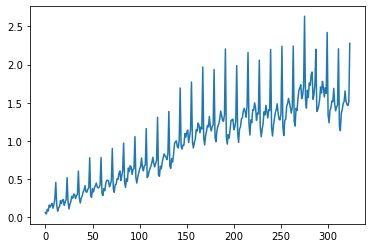

In [54]:
ts = dataset.LiquorSales
ts = ts/np.mean(ts)
plt.plot(ts);

This timeseries data observes seasonality, we will use various forecasting techniques mimicking this pattern inorder to predict future liquor sales for united states

### Data Preprocessing

In [4]:
#Dropping the columns which are not part of features to our model
dataset.drop(['Time', 'Month', 'Year'],axis=1,inplace=True)

 Since neural networks and recurrent neural networks perform better with scaled data hence scaling our data for US liquor

In [57]:
scaler_minmax = MinMaxScaler()
dataset["LiquorSales"]=scaler_minmax.fit_transform(np.array(dataset.LiquorSales).reshape(-1,1))

We will use previous 12 months observation across time to forecast the current months liquor sales.
Below code adds new columns for 12 months with respect to the liquor sales for the existing month.
This process will allow to engineer feature (month1-month12) used for predicting liquor sales.

In [7]:
for i in range(1,13):
    dataset["month"+str(i)]=dataset["LiquorSales"].shift(i)

In [8]:
dataset.tail(5)

,LiquorSales,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
331,0.576906,0.628471,0.576025,0.565888,0.535919,0.518290,0.431027,0.451300,0.838255,0.557955,0.549141,0.529749,0.562362
332,0.562362,0.576906,0.628471,0.576025,0.565888,0.535919,0.518290,0.431027,0.451300,0.838255,0.557955,0.549141,0.529749
333,0.555751,0.562362,0.576906,0.628471,0.576025,0.565888,0.535919,0.518290,0.431027,0.451300,0.838255,0.557955,0.549141
334,0.573821,0.555751,0.562362,0.576906,0.628471,0.576025,0.565888,0.535919,0.518290,0.431027,0.451300,0.838255,0.557955
335,0.865580,0.573821,0.555751,0.562362,0.576906,0.628471,0.576025,0.565888,0.535919,0.518290,0.431027,0.451300,0.838255


Dropping first 12 observations containing nan values since our lag here is 12 and re indexing so that the order of timeseries data doesnot change

In [9]:
dataset=dataset[12:].reset_index(drop=True)

The below splitted dataset will be used for feed forward nwural network 

In [10]:
#Splitting the dataset into train and test
train_dataset = dataset.sample(frac=0.7,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('LiquorSales')
test_labels = test_dataset.pop('LiquorSales')

Converting training and test labels into arrays and features into a 3 dimensional array as keras RNN, LSTM and GRU takes as input a 3 dimensional array

In [14]:
trainX = np.array(train_dataset)
testX = np.array(test_dataset)

In [15]:
trainY= np.array(train_labels)
testY= np.array(test_labels)

Reshaping the features into 3D array with dimensions (number of observations, time steps , number of features)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(227, 1, 12)

The below class will be used for performance evaluation with respect to time elapsed while training the model to reach a minimum mean squared error across trained epochs

In [17]:
#create a timehistory class to get a time for building a network
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

### Model Performance Comparison (FNN,BPTT,LSTM,GRU)

For comparing model performance across different networks we will consider 2 types of comparison :<br><br>
    1.Qualitative(Least MSE) : Determining which model reaches a competitive MSE across when trained across same number of epochs and batch size. The model coverging faster to the minimum mse will be rated higher.<br>
    2.Computational Effort : The model taking lesser amount of time to build, resulting lesser mse score will be rated higher in this type.<br><br>
We will decide the best model for this problem statement based on the tradeoff between the above two scenarios

### a. Feed Forward Network (Plain Back Propagation)

For this problem statement we will create a n-2n-1 feed forward neural network since we have our feature vector considering lags from past 12 months as feature inputs so will be our input shape for the dense layer.

In [18]:
np.random.seed(11)
tf.random.set_seed(11)

In [20]:
def create_model_fnn():
  model = keras.Sequential([
    layers.Dense(24, activation='tanh', input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])


  model.compile(loss='mse',
                optimizer="adam",
                metrics=['mse'])
  return model

In [21]:
#Looking at the neural network model features (shapes and parameters)
ff_model = create_model_fnn()
ff_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                312       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Training the fnn model
EPOCHS = 400
time_callback1 = TimeHistory()

history = ff_model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_data = (test_dataset,test_labels), verbose=0,
  callbacks=[tfdocs.modeling.EpochDots(), time_callback1], batch_size=12)


Epoch: 0, loss:0.0425,  mse:0.0425,  val_loss:0.0308,  val_mse:0.0308,  
....................................................................................................
Epoch: 100, loss:0.0011,  mse:0.0011,  val_loss:0.0015,  val_mse:0.0015,  
....................................................................................................
Epoch: 200, loss:0.0012,  mse:0.0012,  val_loss:0.0018,  val_mse:0.0018,  
....................................................................................................
Epoch: 300, loss:0.0012,  mse:0.0012,  val_loss:0.0015,  val_mse:0.0015,  
....................................................................................................

In [23]:
#looking at the improvement in MSE (learning) at the end of our training

hist_info = pd.DataFrame(history.history)
hist_info['epoch'] = history.epoch
hist_info.tail()

,loss,mse,val_loss,val_mse,epoch
395,0.000984,0.000984,0.002025,0.002025,395
396,0.000986,0.000986,0.001521,0.001521,396
397,0.001038,0.001038,0.001993,0.001993,397
398,0.001159,0.001159,0.001774,0.001774,398
399,0.001333,0.001333,0.003122,0.003122,399


In [59]:
print("BEST MSE of FNN :", history.history.get('val_loss')[-1])

BEST MSE of FNN : 0.00312247802503407


The below graph shows the variation mse with plain back propagation. Manual tuning for parameter activation function("sigmoid","tanh") was done with "SGD" and "adam" as optimizer. The best model performed with activation function as "tanh" and optimizer as "adam" with MSE score 0.003

Text(0, 0.5, 'MSE [LiquorSales]')

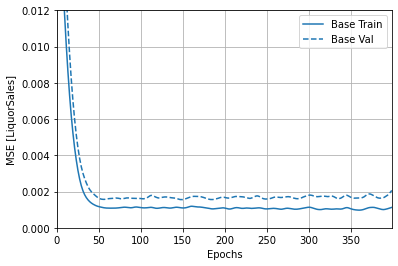

In [24]:
#Results: MSE on the y-axis, Number of weight updates on the x-axis(epochs)

history_plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
history_plotter.plot({'Base': history}, metric = "mse")
plt.ylim([0, 0.012])
plt.ylabel('MSE [LiquorSales]')

### b. RNN (Back Propagation through time)

In [25]:
np.random.seed(121)
tf.random.set_seed(121)

Keras RNN module takes 3 dimensional inputs(no. of observations, step size, number of features). We will use our 3D numpy array features prepared earlier for this purpose

In [26]:
trainX.shape

(227, 1, 12)

In [28]:
# SimpleRNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=1, input_shape=(trainX.shape[1],trainX.shape[2]), activation = 'tanh'))
model_rnn.add(Dense(1)) 
model_rnn.compile(loss='mse', optimizer="adam", metrics=['mse'])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 14        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [29]:
EPOCHS = 400
time_callback2 = TimeHistory()
history2 = model_rnn.fit(
  trainX, trainY,
  epochs=EPOCHS, validation_data = (testX,testY), verbose=0,
  callbacks=[tfdocs.modeling.EpochDots(),time_callback2], batch_size=12)


Epoch: 0, loss:0.0998,  mse:0.0998,  val_loss:0.0824,  val_mse:0.0824,  
....................................................................................................
Epoch: 100, loss:0.0057,  mse:0.0057,  val_loss:0.0075,  val_mse:0.0075,  
....................................................................................................
Epoch: 200, loss:0.0035,  mse:0.0035,  val_loss:0.0048,  val_mse:0.0048,  
....................................................................................................
Epoch: 300, loss:0.0014,  mse:0.0014,  val_loss:0.0022,  val_mse:0.0022,  
....................................................................................................

In [30]:
#looking at the improvement in MSE (learning) at the end of our training

hist_info2 = pd.DataFrame(history2.history)
hist_info2['epoch'] = history2.epoch
hist_info2.tail()

,val_loss,val_mse,loss,mse,epoch
395,0.001618,0.001618,0.000991,0.000991,395
396,0.001627,0.001627,0.000953,0.000953,396
397,0.001621,0.001621,0.000949,0.000949,397
398,0.001623,0.001623,0.000953,0.000953,398
399,0.001659,0.001659,0.000959,0.000959,399


In [61]:
print("BEST MSE of BPTT(Simple RNN) :", history2.history.get('val_loss')[-1])

BEST MSE of BPTT(Simple RNN) : 0.0016585167243263021


The best model performed with 0.0016 MSE. The below graph shows the variation mse with back propagation through time using Simple RNN. The parameters "tanh" as activation and "adam" as optimizer performed best with manual tuning.

Text(0, 0.5, 'MSE [LiquorSales]')

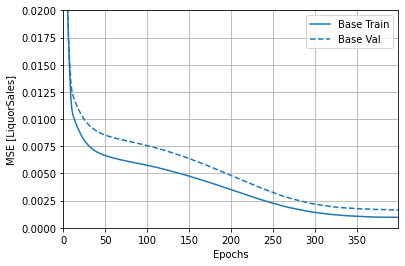

In [31]:
#Results: MSE on the y-axis, Number of weight updates on the x-axis(epochs)
history_plotter2 = tfdocs.plots.HistoryPlotter(smoothing_std=2)
history_plotter2.plot({'Base': history2}, metric = "mse")
plt.ylim([0, 0.02])
plt.ylabel('MSE [LiquorSales]')

### c. LSTM

In [32]:
np.random.seed(132)
tf.random.set_seed(132)


Creating LSTM model with 1 LSTM unit. In Keras LSTM model also consumes features in 3 dimensional array format.

In [33]:
trainX.shape

(227, 1, 12)

In [34]:
model_lstm = Sequential()
model_lstm.add(LSTM(1, input_shape=(trainX.shape[1],trainX.shape[2]),activation='tanh'))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer="adam", metrics=['mse'])
model_lstm.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


In [35]:

EPOCHS = 400
time_callback3 = TimeHistory()
history3 = model_lstm.fit(
  trainX, trainY,
  epochs=EPOCHS, validation_data = (testX,testY), verbose=0,
  callbacks=[tfdocs.modeling.EpochDots(),time_callback3], batch_size=12)


Epoch: 0, loss:0.1826,  mse:0.1826,  val_loss:0.1969,  val_mse:0.1969,  
....................................................................................................
Epoch: 100, loss:0.0053,  mse:0.0053,  val_loss:0.0081,  val_mse:0.0081,  
....................................................................................................
Epoch: 200, loss:0.0027,  mse:0.0027,  val_loss:0.0042,  val_mse:0.0042,  
....................................................................................................
Epoch: 300, loss:0.0013,  mse:0.0013,  val_loss:0.0021,  val_mse:0.0021,  
....................................................................................................

In [36]:
#looking at the improvement in MSE (learning) at the end of our training

hist_info3 = pd.DataFrame(history3.history)
hist_info3['epoch'] = history3.epoch
hist_info3.tail()

,val_loss,val_mse,loss,mse,epoch
395,0.001918,0.001918,0.000985,0.000985,395
396,0.001752,0.001752,0.001028,0.001028,396
397,0.001734,0.001734,0.000993,0.000993,397
398,0.001807,0.001807,0.001002,0.001002,398
399,0.001770,0.001770,0.001009,0.001009,399


In [62]:
print("BEST MSE of LSTM :", history3.history.get('val_loss')[-1])

BEST MSE of LSTM : 0.0017700497248238816


The best model performed with 0.0017 MSE. The below graph shows the variation mse with back propagation through time using LSTM.

Text(0, 0.5, 'MSE [LiquorSales]')

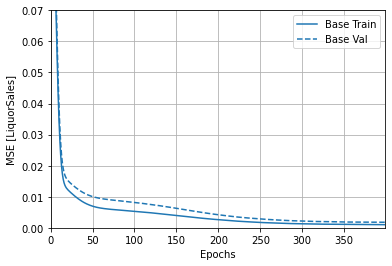

In [37]:
#Results: MSE on the y-axis, Number of weight updates on the x-axis(epochs)
history_plotter3 = tfdocs.plots.HistoryPlotter(smoothing_std=2)
history_plotter3.plot({'Base': history3}, metric = "mse")
plt.ylim([0, 0.07])
plt.ylabel('MSE [LiquorSales]')

### d. GRU

In [38]:
np.random.seed(125)
tf.random.set_seed(125)

Creating GRU model with 1 GRU unit. In Keras GRU model also consumes features in 3 dimensional array format.

In [39]:
# Create GRU model
model_gru = Sequential()
model_gru.add(GRU(1, input_shape=(trainX.shape[1],trainX.shape[2]), activation='tanh'))
model_gru.add(Dense(1))
model_gru.compile(loss='mse', optimizer="adam", metrics=['mse'])
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________


In [40]:
EPOCHS = 400
time_callback4 = TimeHistory()
history4 = model_gru.fit(
  trainX, trainY,
  epochs=EPOCHS, validation_data = (testX,testY), verbose=0,
  callbacks=[tfdocs.modeling.EpochDots(),time_callback4], batch_size=12)


Epoch: 0, loss:0.3859,  mse:0.3859,  val_loss:0.3935,  val_mse:0.3935,  
....................................................................................................
Epoch: 100, loss:0.0064,  mse:0.0064,  val_loss:0.0096,  val_mse:0.0096,  
....................................................................................................
Epoch: 200, loss:0.0032,  mse:0.0032,  val_loss:0.0051,  val_mse:0.0051,  
....................................................................................................
Epoch: 300, loss:0.0013,  mse:0.0013,  val_loss:0.0023,  val_mse:0.0023,  
....................................................................................................

In [41]:
#looking at the improvement in MSE (learning) at the end of our training

hist_info4 = pd.DataFrame(history4.history)
hist_info4['epoch'] = history4.epoch
hist_info4.tail()

,val_loss,val_mse,loss,mse,epoch
395,0.001860,0.001860,0.001003,0.001003,395
396,0.001723,0.001723,0.001026,0.001026,396
397,0.001716,0.001716,0.001004,0.001004,397
398,0.001914,0.001914,0.001043,0.001043,398
399,0.001844,0.001844,0.001095,0.001095,399


In [64]:
print("BEST MSE of LSTM :", history4.history.get('val_loss')[-1])

BEST MSE of LSTM : 0.0018437132415614935


The best model performed with 0.0018 MSE. The below graph shows the variation of mse with back propagation through time using GRU.

Text(0, 0.5, 'MSE [LiquorSales]')

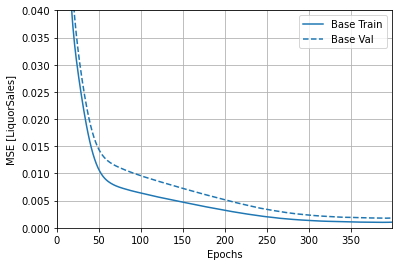

In [42]:
#Results: MSE on the y-axis, Number of weight updates on the x-axis(epochs)
history_plotter4 = tfdocs.plots.HistoryPlotter(smoothing_std=2)
history_plotter4.plot({'Base': history4}, metric = "mse")
plt.ylim([0, 0.04])
plt.ylabel('MSE [LiquorSales]')

### Model Performance Comparison

#### 1. MSE Comparison (Qualitative) : The below graph shows the comparison and competition between keras sequential models Feed Forward Neural Network, Simple RNN, LSTM, GRU on validation MSE across 400 Epochs<br>


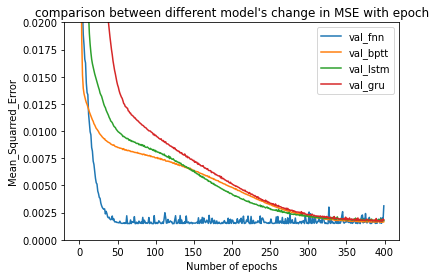

In [43]:
plt.plot(history.history.get('val_loss'))
plt.plot(history2.history.get('val_loss'))
plt.plot(history3.history.get('val_loss'))
plt.plot(history4.history.get('val_loss'))
plt.xlabel('Number of epochs')
plt.ylabel('Mean_Squarred_Error')
plt.title('comparison between different model\'s change in MSE with epoch')
plt.legend(['val_fnn', 'val_bptt','val_lstm','val_gru'], loc='upper right')
plt.ylim([0, 0.02])
plt.show()

We can clearly see that feed forward neural network reaches the minimum MSE the quickest followed by LSTM which outperforms Simple RNN(BPTT) after almost 130 epochs and GRU at the last <br>
Model Rank : Feed Forward Network > LSTM > BPTT > GRU

#### 2. Computational Effort (Time Elapsed) : The below graph shows the comparison and competition between keras sequential models Feed Forward Neural Network, Simple RNN, LSTM, GRU on time taken to build and reach a better MSE<br>

In [71]:
fnn_time = list(time_callback1.times)
rnn_time = list(time_callback2.times)
lstm_time = list(time_callback3.times)
gru_time = list(time_callback4.times)
t_elapsed = [sum(fnn_time), sum(rnn_time), sum(lstm_time), sum(gru_time)]
val_mse_all = [history.history.get('val_loss')[-1],history2.history.get('val_loss')[-1],history3.history.get('val_loss')[-1],history4.history.get('val_loss')[-1]]
models = ['FNN', 'RNN', 'LSTM', 'GRU']

In [83]:
history4.history.get('val_loss')[-1]

0.0018437132415614935

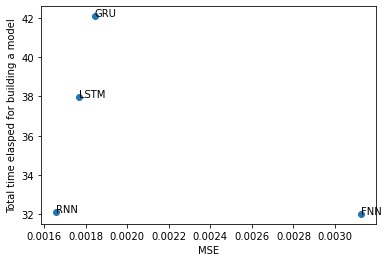

In [72]:
fig, ax = plt.subplots()
ax.scatter(val_mse_all, t_elapsed)
plt.ylabel('Total time elasped for building a model')
plt.xlabel('MSE')

for i, txt in enumerate(models):
    ax.annotate(txt, (val_mse_all[i], t_elapsed[i]))

We can clearly see that BPTT(Simple RNN) takes least amount of time reaching the least MSE compared to other models. GRU and LSTM have lesser MSE compared to Plain Back Propagating Feed Forward Network but takes maximum amount of computaional time to build.<br>
Model Rank : BPTT(SimpleRNN) > LSTM > GRU > FNN

### Conclusion :<br>
Looking at the two types of performance comparison we can conclude reaching a trade off that LSTM model performs decent holding second position in both comparison types. Hence we can choose LSTM as best model for this problem statement of forcasting Liquor Sales in United States between 1980 to 2007 sales data <br>



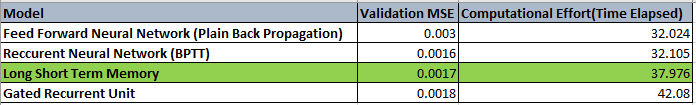

### References : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM <br>
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ <br>
https://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/ <br>
https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767 <br>
https://intellipaat.com/community/25190/record-the-computation-time-for-each-epoch-in-keras-during-model-fit